<a href="https://colab.research.google.com/github/ljbcoder/Project-Tensorflow/blob/main/EntropyQ_Implementing_Surprise_in_RL_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENTROPYQ: Implementing Surprise in RL Agents**

**Currently working to see if adding surprise to RL algorithms to stimulate learning deems effective.**


```
1. Boost the TD-Learning error to learn small on common occurences/ learn big on uncommon experiences using entropy

2. Boost Transitional probability learning through entropy
```







**WORK IN PROGRESS...**

In [264]:
import numpy as np

class GridWorld:
    def __init__(self, width, height, terminal_states, stochasticity=0.2):
        self.width = width
        self.height = height
        self.terminal_states = terminal_states
        self.state = (0, 0)
        self.stochasticity = stochasticity  # probability of taking a random action

        self.actions = ['up', 'down', 'left', 'right']
        self.action_effects = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1),
        }

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        # With some probability, take a random action
        if np.random.rand() < self.stochasticity:
            action = np.random.choice(self.actions)

        dx, dy = self.action_effects[action]
        x, y = self.state
        nx, ny = x + dx, y + dy
        nx, ny = np.clip(nx, 0, self.height - 1), np.clip(ny, 0, self.width - 1)

        self.state = (nx, ny)
        reward = -1
        done = self.state in self.terminal_states
        if done:
            reward = 0

        return self.state, reward, done


In [265]:
from collections import defaultdict
import numpy as np

class StableEntropyQAgent:
    def __init__(self, env, tau=0.05, gamma=0.9, alpha=0.1, min_visits=1,sensitivity = 10):
        self.env = env
        self.Q = defaultdict(float)
        self.actions = env.actions

        # Learning params
        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.min_visits = min_visits
        self.sensitivity = sensitivity

        # Model for transitions
        self.transition_reward_counts = defaultdict(lambda: defaultdict(int))
        self.transition_reward_probs = defaultdict(lambda: defaultdict(float))
        self.visit_counts = defaultdict(int)

    def select_action(self, s, eps=0.2):
        if np.random.rand() < eps:
            return np.random.choice(self.actions)
        qs = [self.Q[(s, a)] for a in self.actions]
        return self.actions[np.argmax(qs)]

    def update_transition_model(self, s, a, s_next, r):
        key = (s, a)
        pair = (s_next, r)

        current_prob = self.transition_reward_probs[key].get(pair, 1e-6)
        surprise = -np.log(current_prob + 1e-6)

        #Apply weight to more suprising events --> Sensitivity is a metric more susceptible to this

        scaled_count = 1 + self.sensitivity * surprise
        self.transition_reward_counts[key][pair] += scaled_count
        self.visit_counts[key] += scaled_count

        total = sum(self.transition_reward_counts[key].values())
        for p in self.transition_reward_counts[key]:
            self.transition_reward_probs[key][p] = self.transition_reward_counts[key][p] / total


    def compute_shannon_entropy(self, s, a):
        probs = self.transition_reward_probs[(s, a)].values()
        if not probs:
            return 0.0
        return -sum(p * np.log(p + 1e-10) for p in probs)

    def update(self, s, a, r, s_next):
        # Update transition model
        self.update_transition_model(s, a, s_next, r)

        # TD learning
        max_next_q = max([self.Q[(s_next, a2)] for a2 in self.actions])
        td_target = r + self.gamma * max_next_q

        #Increasing weight of TD target (Positive e)
        # Apply entropy penalty only after enough visits
        if self.visit_counts[(s, a)] >= self.min_visits:
            entropy = self.compute_shannon_entropy(s, a)
            penalty = self.tau * entropy
            td_target *= (1+penalty)  # or += if encouraging exploration

        td_error = td_target - self.Q[(s, a)]
        self.Q[(s, a)] += self.alpha * td_error

            # Debug print
            # print(f"(s={s}, a={a}) Entropy={entropy:.3f}, Penalty={penalty:.3f}")




In [266]:
#IN TESTING...

import numpy as np
from collections import defaultdict

class FreeEnergyQAgent:
    def __init__(self, actions, tau=0.05, gamma=0.9, alpha=0.1):
        self.Q = defaultdict(float)
        self.actions = actions
        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau

        self.transition_counts = defaultdict(lambda: defaultdict(int))
        self.transition_probs = defaultdict(lambda: defaultdict(float))

    def select_action(self, s, eps=0.1):
        if np.random.rand() < eps:
            return np.random.choice(self.actions)
        f_vals = [self.get_free_energy(s, a) for a in self.actions]
        return self.actions[np.argmin(f_vals)]

    def update_transition_model(self, s, a, s_next):
        key = (s, a)
        self.transition_counts[key][s_next] += 1

        total = sum(self.transition_counts[key].values())
        for s_next_key in self.transition_counts[key]:
            self.transition_probs[key][s_next_key] = self.transition_counts[key][s_next_key] / total

    def compute_entropy(self, s, a):
        probs = self.transition_probs[(s, a)].values()
        return -sum(p * np.log(p + 1e-10) for p in probs) if probs else 0.0

    def get_free_energy(self, s, a):
        entropy = self.compute_entropy(s, a)
        return self.Q[(s, a)] - self.tau * entropy

    def update(self, s, a, r, s_next):
        self.update_transition_model(s, a, s_next)
        max_next_q = max(self.Q[(s_next, a2)] for a2 in self.actions)
        td_target = r + self.gamma * max_next_q
        td_error = td_target - self.Q[(s, a)]
        self.Q[(s, a)] += self.alpha * td_error


In [267]:
class StandardQAgent:
    def __init__(self, env, gamma=0.9, alpha=0.1):
        self.env = env
        self.actions = env.actions
        self.Q = defaultdict(float)
        self.gamma = gamma
        self.alpha = alpha

    def select_action(self, s, eps=0.2):
        if np.random.rand() < eps:
            return np.random.choice(self.actions)
        qs = [self.Q[(s, a)] for a in self.actions]
        return self.actions[np.argmax(qs)]

    def update(self, s, a, r, s_next):
        max_next_q = max([self.Q[(s_next, a2)] for a2 in self.actions])
        target = r + self.gamma * max_next_q
        self.Q[(s, a)] += self.alpha * (target - self.Q[(s, a)])


In [268]:
class SoftQAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, temperature=1.0):
        self.env = env
        self.Q = defaultdict(float)
        self.actions = env.actions
        self.alpha = alpha
        self.gamma = gamma
        self.temperature = temperature  # controls entropy bonus

    def select_action(self, s, eps=0.2):
        if np.random.rand() < eps:
            return np.random.choice(self.actions)
        # Softmax action selection
        q_vals = np.array([self.Q[(s, a)] for a in self.actions])
        preferences = q_vals / self.temperature
        exp_prefs = np.exp(preferences - np.max(preferences))
        probs = exp_prefs / np.sum(exp_prefs)
        return np.random.choice(self.actions, p=probs)

    def update(self, s, a, r, s_next):
        q_vals_next = np.array([self.Q[(s_next, a2)] for a2 in self.actions])
        logsumexp = np.log(np.sum(np.exp(q_vals_next / self.temperature)))
        soft_value = self.temperature * logsumexp

        target = r + self.gamma * soft_value
        self.Q[(s, a)] += self.alpha * (target - self.Q[(s, a)])


In [269]:
# Training function
def train_agents(num_episodes=300):
    env_std = GridWorld(20, 20, terminal_states=[(15, 10)], stochasticity=0.3)
    env_ent = GridWorld(20, 20, terminal_states=[(15, 10)], stochasticity=0.3)
    env_soft = GridWorld(20, 20, terminal_states=[(15, 10)], stochasticity=0.3)

    std_agent = StandardQAgent(env_std)
    ent_agent = StableEntropyQAgent(env_ent, tau=0.05)
    soft_agent = SoftQAgent(env_soft, temperature=1.0)

    std_rewards, ent_rewards, soft_rewards = [], [], []

    for ep in range(num_episodes):
        # Standard Q
        s, done, total_r = env_std.reset(), False, 0
        while not done:
            a = std_agent.select_action(s)
            s_next, r, done = env_std.step(a)
            std_agent.update(s, a, r, s_next)
            s, total_r = s_next, total_r + r
        std_rewards.append(total_r)

        # Entropy-Penalized Q
        s, done, total_r = env_ent.reset(), False, 0
        while not done:
            a = ent_agent.select_action(s)
            s_next, r, done = env_ent.step(a)
            ent_agent.update(s, a, r, s_next)
            s, total_r = s_next, total_r + r
        ent_rewards.append(total_r)

        # Soft Q
        s, done, total_r = env_soft.reset(), False, 0
        while not done:
            a = soft_agent.select_action(s)
            s_next, r, done = env_soft.step(a)
            soft_agent.update(s, a, r, s_next)
            s, total_r = s_next, total_r + r
        soft_rewards.append(total_r)

    return std_agent, ent_agent, soft_agent, std_rewards, ent_rewards, soft_rewards

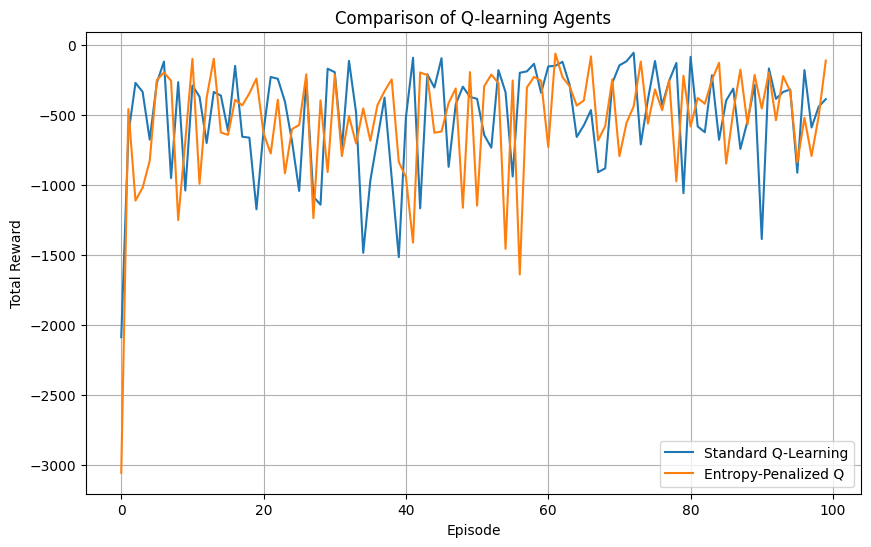

In [270]:
import matplotlib.pyplot as plt
def plot_reward_comparison(std_rewards, ent_rewards, soft_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(std_rewards, label='Standard Q-Learning')
    plt.plot(ent_rewards, label='Entropy-Penalized Q')
    # plt.plot(soft_rewards, label='Soft Q-Learning (MaxEnt)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Comparison of Q-learning Agents')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run training and plot
std_agent, ent_agent, soft_agent, std_rewards, ent_rewards, soft_rewards = train_agents(num_episodes=100)
plot_reward_comparison(std_rewards, ent_rewards, soft_rewards)


In [271]:
# std_agent, ent_agent, soft_agent, fe_agent, std_rewards, ent_rewards, soft_rewards, fe_rewards = train_agents(num_episodes=300)
# plot_reward_comparison(std_rewards, ent_rewards, soft_rewards, fe_rewards)



In [272]:
import matplotlib.pyplot as plt
import numpy as np

def plot_q_value_heatmap(agent, title='Q-Value Heatmap'):
    grid_height = agent.env.height
    grid_width = agent.env.width
    q_values = np.zeros((grid_height, grid_width))

    for x in range(grid_height):
        for y in range(grid_width):
            state = (x, y)
            q_max = max(agent.Q[(state, a)] for a in agent.actions)
            q_values[x, y] = q_max

    plt.figure(figsize=(10, 8))
    plt.imshow(q_values, cmap='viridis', origin='upper')
    plt.colorbar(label='Max Q-value')
    plt.title(title)
    plt.xlabel('Y')
    plt.ylabel('X')

    for x in range(grid_height):
        for y in range(grid_width):
            plt.text(y, x, f"{q_values[x, y]:.1f}", ha='center', va='center', color='white')

    plt.grid(False)
    plt.show()


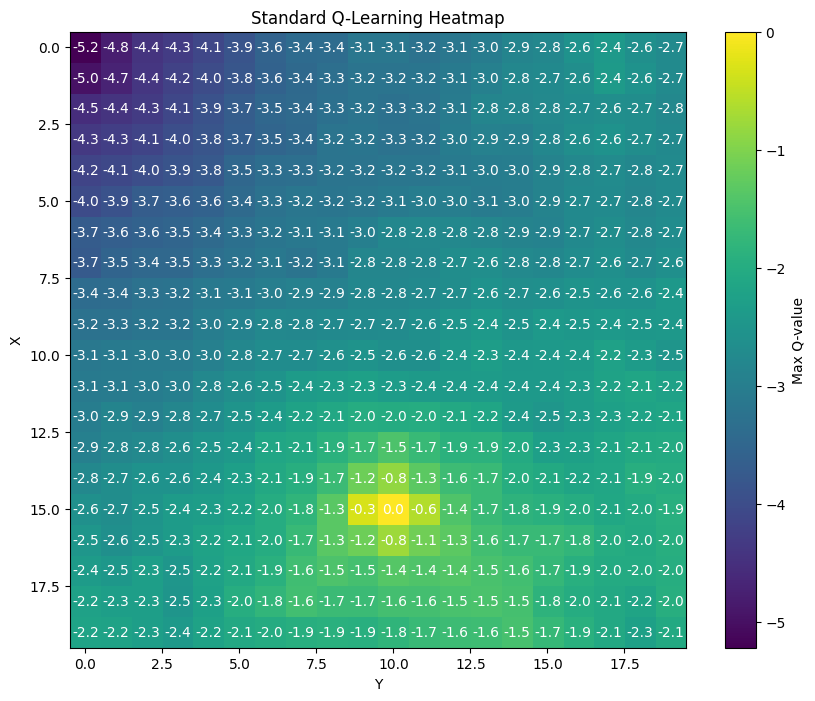

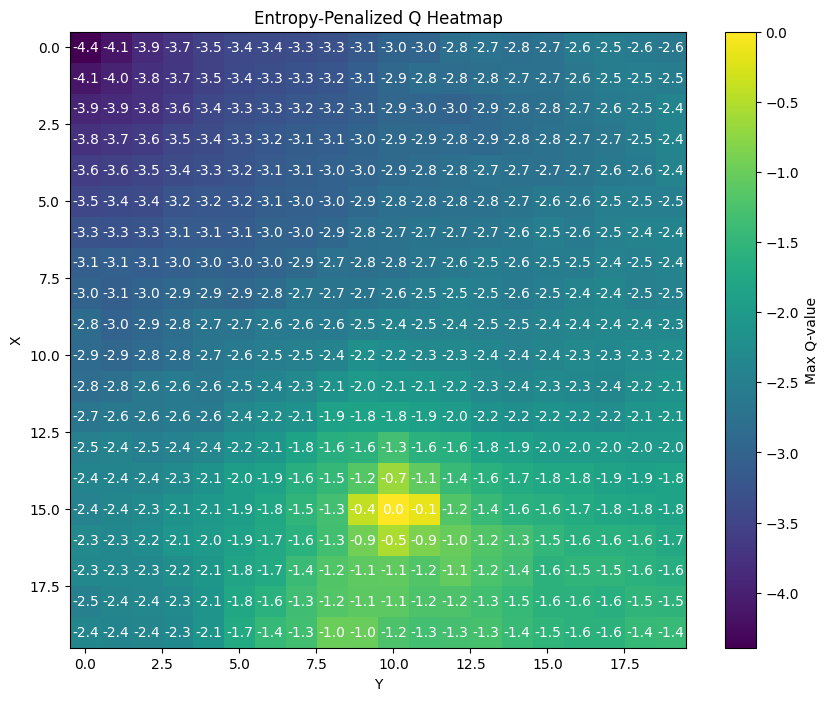

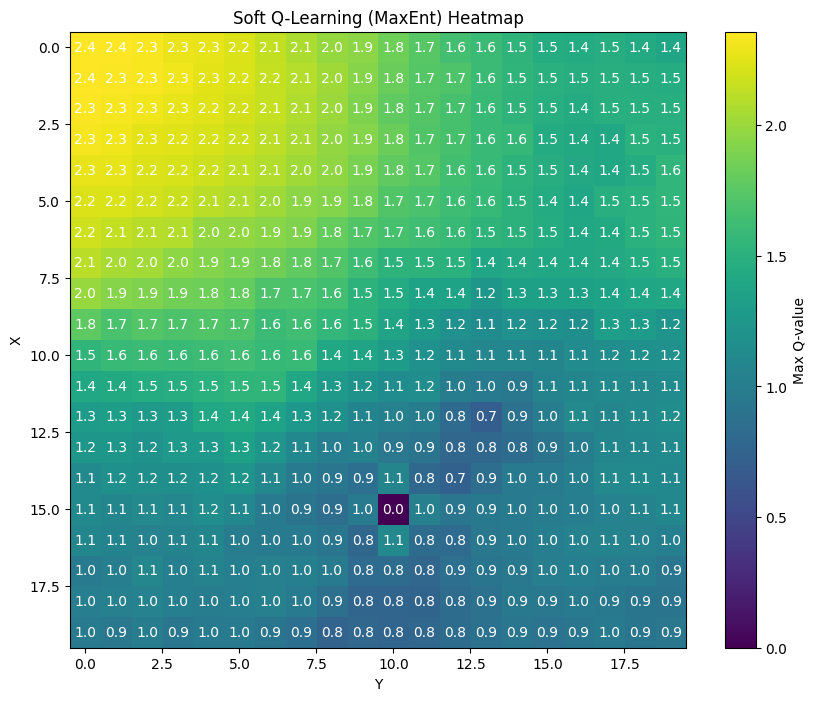

In [273]:
plot_q_value_heatmap(std_agent, title='Standard Q-Learning Heatmap')
plot_q_value_heatmap(ent_agent, title='Entropy-Penalized Q Heatmap')
plot_q_value_heatmap(soft_agent, title='Soft Q-Learning (MaxEnt) Heatmap')


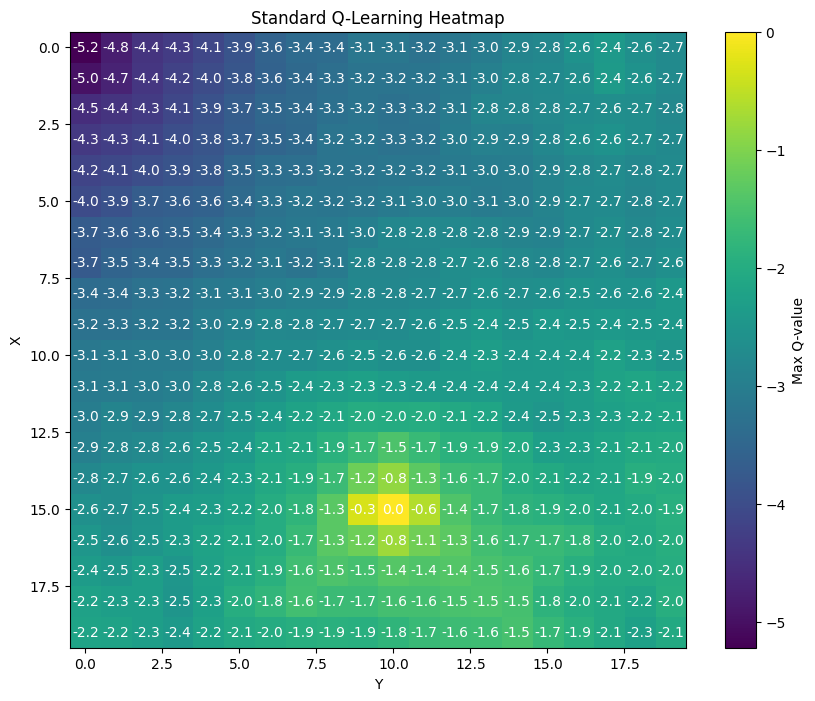

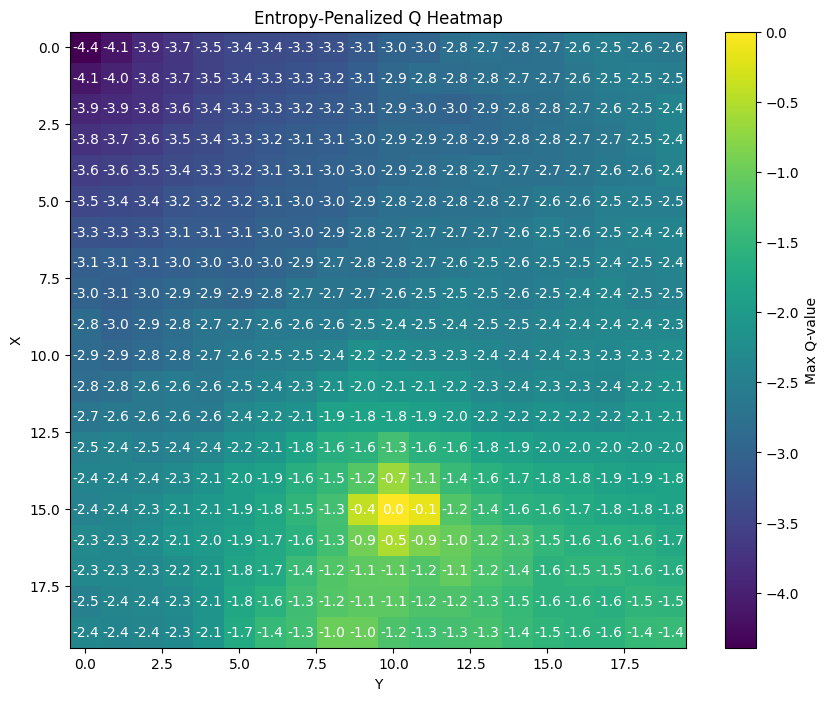

In [274]:
# After training
plot_q_value_heatmap(std_agent, title='Standard Q-Learning Heatmap')
plot_q_value_heatmap(ent_agent, title='Entropy-Penalized Q Heatmap')
